In [1]:
%matplotlib ipympl
import numpy as np
import astropy.io.fits as pyfits 
from astropy.table import Table, Column

import matplotlib.pyplot as plt
from matplotlib import cm



In [2]:
path = "F:/CodedMasks/Spectral analysis/WFM/"
rmf = "wfm.rmf"
arf = "wfm.arf"

In [3]:
def read_ebounds(filermf, header2=False):
    with pyfits.open(filermf) as hdu_list:
        header_2 = hdu_list[2].header

        data = hdu_list[2].data
        ebounds = Table(data)
        print(ebounds.keys())
        if not header2:
            return ebounds
        else:
            return ebounds, header_2

In [4]:
def write_spectrum_counts(channels, counts, exposure, rmf_file, arf_file, outfile, telescope, instrument):
    print(outfile)
    n_channels = len(channels)
    iqal = np.zeros(n_channels)                    # Fattore di qualita'
    igr = np.ones(n_channels)                    # Fattore di grouping


    # Genera estensione principale
    col1=pyfits.Column(name='CHANNEL',  format='J', unit='none',   array=channels) 
    col2=pyfits.Column(name='COUNTS',   format='J', unit='count',  array=counts)
    col3=pyfits.Column(name='QUALITY',  format='I', unit='none',   array=iqal)
    col4=pyfits.Column(name='GROUPING', format='I', unit='none',   array=igr)

    tbhdu = pyfits.BinTableHDU.from_columns([col1, col2, col3, col4]) 

    tbhdu.header.set('EXTNAME','SPECTRUM','name of this binary table extension') 
    tbhdu.header.set('TELESCOP',telescope,'Telescope name') 
    tbhdu.header.set('INSTRUME',instrument,'Instrument name')
    tbhdu.header.set('FILTER  ','none','Instrument filter in use')
    tbhdu.header.set('EXPOSURE', exposure,'Exposure time(s)')                 # parametro input
    tbhdu.header.set('EFFAREA', 1.0000E+00,'effective area factor')
    tbhdu.header.set('AREASCAL',1.0000E+00,'nominal effective area')
    tbhdu.header.set('BACKSCAL',1.0000E+00,'background scale factor')
    tbhdu.header.set('BACKFILE','none ','background FITS file')
    tbhdu.header.set('CORRFILE','none','correlation FITS file')
    tbhdu.header.set('CORRSCAL',0.0,'Correlation scale factor')
    tbhdu.header.set('RESPFILE',rmf_file,'redistribution matrix file (RMF)')    # parametro input
    tbhdu.header.set('ANCRFILE',arf_file,'ancillary response file (ARF)')    # parametro input
    tbhdu.header.set('XFLT0001','none','XSPEC selection filter description')
    tbhdu.header.set('CHANTYPE','PHA','Channel assigned by detector electronics')
    tbhdu.header.set('POISSERR',True,'Poissonian error assumed')
    tbhdu.header.set('STAT_ERR',0,'no statistical error specified') 
    tbhdu.header.set('SYS_ERR', 0,'no systematic error specified') 
    tbhdu.header.set('DETCHANS',n_channels,'Total no. detector channels ')
    tbhdu.header.set('CREATOR','python-pyfits','program which created the PHA dataset')
    tbhdu.header.set('HDUCLASS','OGIP','organization of the file format in use')
    tbhdu.header.set('HDUCLAS1','SPECTRUM','extension contains a PHA dataset')
    tbhdu.header.set('HDUCLAS2','NET','type of data stored') # 'TOTAL' = src + bg, 'NET' = src, 'BKG' = bkg
    tbhdu.header.set('HDUCLAS3','COUNT','type of data stored')
    tbhdu.header.set('HDUCLAS4','TYPE:I','type of data stored')
    tbhdu.header.set('HDUVERS','1.2.1','version of the HDUCLASS format in use')
    tbhdu.header.set('HDUVERS1','1.2.1','version of the HDUCLAS1 format in use')
    tbhdu.header.set('TLMIN1',0,'Lowest legal channel number')
    tbhdu.header.set('TLMAX1',n_channels-1,'Highest legal channel number')


    # Genera primary extension
    prhdu = pyfits.PrimaryHDU()
    prhdu.header.set('CONTENT','PHA SPECTRUM','spectrum file')
    prhdu.header.set('TELESCOP', telescope,'Telescope name')
    prhdu.header.set('INSTRUME', instrument,'Instrument name')

    # Appende le estensioni create e le scrive su file
    hdulist = pyfits.HDUList([prhdu])
    hdulist.append(tbhdu)
    hdulist.writeto(outfile, overwrite=True)

In [5]:
ebounds = read_ebounds(rmf)

['CHANNEL', 'E_MIN', 'E_MAX']


In [6]:
path_evt = "F:/CodedMasks/Spectral analysis/WFM/20250612_galctr_rxte_sax_2-30keV_10ks_infdense_lises_sources_cxb/"
file_evt = path_evt + "galctr_rxte_sax_2-30keV_10ks_infdense_lines_sources_cxb_cam1a_detected.fits"


with pyfits.open(file_evt) as hdu_list:
    header1 = hdu_list[1].header
    data = hdu_list[1].data
    events = Table(data)

In [7]:
def filter_source(data, ra, dec, verbose=False):
    mask = np.ones(len(data), dtype=bool)
    mask &= (np.isclose(data["RA"], ra) & np.isclose(data["DEC"], dec))
    filtered = data[mask]
    if verbose:
        print("Selected", len(filtered), "out of", len(data), "events")

    return filtered

In [8]:
gro1655_ra = 253.5
gro1655_dec = -39.8457984924316

In [9]:
events_filtered = filter_source(events, gro1655_ra, gro1655_dec, verbose=True)

Selected 184492 out of 11877276 events


In [10]:
bins = np.append(ebounds['E_MIN'], ebounds['E_MAX'][-1])
spectrum, _ = np.histogram(events['ENERGY'], bins=bins)

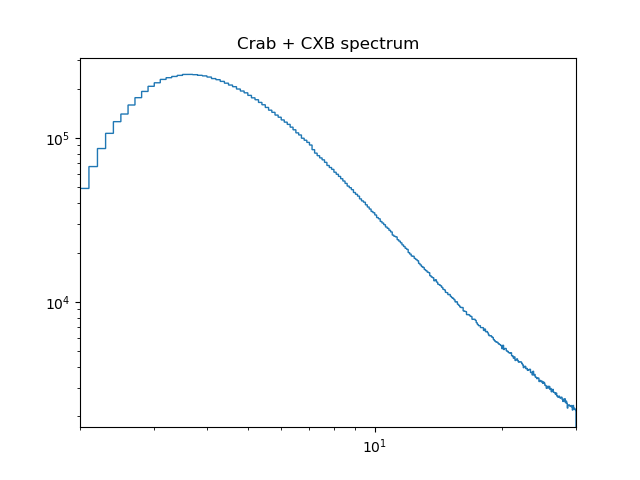

In [11]:
plt.figure()
plt.title('Crab + CXB spectrum')
plt.stairs(spectrum, bins)
plt.yscale('log')
plt.xscale('log')
plt.xlim((2,30))
plt.show()

In [12]:
write_spectrum_counts(ebounds['CHANNEL'], spectrum, 1000, path+rmf, path+arf, path_evt + 'sample_spectrum.pha', 'eXTP', 'WFM')

F:/CodedMasks/Spectral analysis/WFM/20250612_galctr_rxte_sax_2-30keV_10ks_infdense_lises_sources_cxb/sample_spectrum.pha
